# cdli_cat_2_factgrid

__Start Date:__ Jan 25, 2022

__Author:__ Julia Wang & Adam Anderson

__Goal:__ Converting the daily data dump of CDLI in [cdli_cat.csv](https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv) to quick statement in FactGrid.

__CSV:__ [cdli_cat_2_factgrid.csv]() (insert link here when ready)

--------------------------------

__To do for Version 1.0:__

* Read in the CDLI_CAT data

* Select Desired Columns for FactGrid Q-ids:

    * Language
    * Material
    * Museum
    * Provenience
    * Object type
    * Genre
    * Period

* Concatenate
* QuickStatements
* Next Steps

Just to foreshadow what we are looking at (when finished, see section IV for complete list):

We will export the resulting data frame as a CSV with the following fields (plust those listed below in section IV):

| HEADER | qid | Len | Den | P694 | P18 | P121 | P695 | P131 |
| ------ | ---- | --------------- | --------------- | --------- | -------------- | ---- | ---- | --- |
| LOD | (check agianst FG) | designation | (if we can't get this we can make it): | external_id | language | genre | provenience | (always include) |
| (NOTES) | (otherwise leave blank) | (add Lde and Lfr) | (Lang + Object + provenience + period) | CDLI P-number | Q# | Q#| Q# | Q38597 |



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import collections

## I. Read in the Data

In [2]:
url = 'https://media.githubusercontent.com/media/cdli-gh/data/master/cdli_cat.csv'

data = pd.read_csv(url, sep=',')
data.head(6)

<ipython-input-2-80a120bf1dfb>:3: DtypeWarning: Columns (1,2,3,4,6,8,9,10,11,14,16,17,19,22,23,24,25,26,27,28,29,31,32,33,37,39,42,45,46,49,52,53,54,55,57,58,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url, sep=',')


,accession_no,accounting_period,acquisition_history,alternative_years,ark_number,atf_source,atf_up,author,author_remarks,cdli_collation,...,seal_information,stratigraphic_level,subgenre,subgenre_remarks,surface_preservation,text_remarks,thickness,translation_source,width,object_remarks
0,NaN,NaN,NaN,NaN,21198/zz001q0dtm,"Englund, Robert K.",NaN,CDLI,"31x61x18; Lú A 14-16.30-32.48-50; M XVIII, auf...",NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,18,no translation,61,NaN
1,NaN,NaN,NaN,NaN,21198/zz001q0dv4,"Englund, Robert K.",NaN,CDLI,30x48x13; Lú A 13-15.23-25.?; Fundstelle wie W...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,13,no translation,48,NaN
2,NaN,NaN,NaN,NaN,21198/zz001q0dwn,"Englund, Robert K.",NaN,"Englund, Robert K. & Nissen, Hans J.","42x53x19; Vocabulary 9; Qa XVI,2, unter der Ab...",NaN,...,NaN,NaN,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,NaN,NaN,19,no translation,53,NaN
3,NaN,NaN,NaN,NaN,21198/zz001q0dx5,"Englund, Robert K.",NaN,CDLI,26x23x23; Lú A 9-10.?.?; Fundstelle wie W 9123...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,23,no translation,23,NaN
4,NaN,NaN,NaN,NaN,21198/zz001q0dzp,"Englund, Robert K.",NaN,CDLI,"29x36x20; Lú A Vorläufer; Qa XVI,2, unter der ...",NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,20,no translation,36,NaN
5,NaN,NaN,NaN,NaN,21198/zz001q0f0p,"Englund, Robert K.",NaN,CDLI,82x62x19; Lú A Vorläufer; Fundstelle wie W 912...,NaN,...,NaN,NaN,Archaic Lu2 A (witness),NaN,NaN,NaN,19,no translation,62,NaN


In [3]:
data = data.fillna('-')

The columns in the cdli data dump are as below:

In [4]:
data.columns

Index(['accession_no', 'accounting_period', 'acquisition_history',
       'alternative_years', 'ark_number', 'atf_source', 'atf_up', 'author',
       'author_remarks', 'cdli_collation', 'cdli_comments', 'citation',
       'collection', 'composite_id', 'condition_description', 'date_entered',
       'date_of_origin', 'date_remarks', 'date_updated', 'dates_referenced',
       'db_source', 'designation', 'dumb', 'dumb2', 'electronic_publication',
       'elevation', 'excavation_no', 'external_id', 'findspot_remarks',
       'findspot_square', 'genre', 'google_earth_collection',
       'google_earth_provenience', 'height', 'id', 'id_text2', 'id_text',
       'join_information', 'language', 'lineart_up', 'material', 'museum_no',
       'object_preservation', 'object_type', 'period', 'period_remarks',
       'photo_up', 'primary_publication', 'provenience', 'provenience_remarks',
       'publication_date', 'publication_history', 'published_collation',
       'seal_id', 'seal_information', 's

## II. Select Desired Columns

1. We will make a subset of the data from the [cdli_cat.csv](https://github.com/cdli-gh/data/blob/master/cdli_cat.csv) data, which is updated daily in the [cdli-gh/data](https://github.com/cdli-gh/data/blob/master/cdli_cat.csv) GitHub repository.

2. Create a data frame `cdli_cat_df` made up with columns we want to include in linked data, following the CDLI_FGformat described in the google sheet we created for the purpose of obtaining the Qids from FactGrid and Wikidata for linked opend data: [LOD Tablet Dictionary (FG Cuneiform)]((https://docs.google.com/spreadsheets/d/107ly4G5j3im6Hbifqw1HaB66zuqzf7ijN6q8A-WvH8s/edit#gid=1318719558)).

###0. Get a clean cdli_cat_df

In [5]:
cdli_cat_df = pd.DataFrame({'id_text': [], 'external_id': [], 'genre': [], 'subgenre': [], 'subgenre_remarks': [],
                           'language': [], 'material': [], 'object_type': [], 'period': [],
                           'atf_source': [], 'author': [], 'author_remarks': [], 'publication_history': [],
                           'primary_publication': [], 'designation': [], 'publication_date': [], 'provenience': [],
                           'collection': [], 'museum_no': [], 'accession_no': [], 'height': [], 'thickness': [], 'width': [],
                           'object_remarks': [], 'date_of_origin': [], 'translation_source': [], 'date_entered': [],
                           'dates_referenced': [], 'seal_id': [], 'accounting_period': [], 'citation': []
                            })

desired_columns = cdli_cat_df.columns
not_covered_columns = []

for col in desired_columns:
    # if a desired column is found in data, directly use that column in data
    if col in data.columns:
        cdli_cat_df[col] = data[col]
    # if a desired column is not found in data, record the column name
    else:
        not_covered_columns += [col]


cdli_cat_df = cdli_cat_df.fillna('')
cdli_cat_df


,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
0,1,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,18,61,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
1,2,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,13,48,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
2,3,-,Lexical,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,19,53,-,-,no translation,12/4/2001,-,-,-,-
3,4,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,23,23,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
4,5,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,20,36,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353278,532443,-,Legal,-,-,Sumerian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,-,-,-,-,no translation,8/13/2022,-,-,-,-
353279,532444,-,Administrative,-,-,Akkadian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,20,34,-,-,no translation,8/13/2022,-,-,-,-
353280,532445,-,Administrative,-,-,Akkadian,clay,tablet,Old Babylonian (ca. 1900-1600 BC),no atf,...,20,34,-,-,no translation,8/13/2022,-,-,-,-
353281,532446,-,Legal,-,-,Akkadian,clay,tablet & envelope,Old Babylonian (ca. 1900-1600 BC),no atf,...,-,-,-,-,no translation,8/19/2022,-,-,-,-


We can see that all desired columns except for the ones below are available in `data` (cdli daily data dump).

In [6]:
not_covered_columns

[]

Next, we need to convert the content of the desired columns into FG formats. An example of FG can be found [here](https://database.factgrid.de/wiki/Item:Q471142). The rules for conversion is documented in the [demo_FGformat](https://docs.google.com/spreadsheets/d/107ly4G5j3im6Hbifqw1HaB66zuqzf7ijN6q8A-WvH8s/edit#gid=349399460) in the LOD Tablet Dictionary.





### 1 __Language = Language [(P18)](https://database.factgrid.de/wiki/Property:P18) + uncertainty [(P155)](https://database.factgrid.de/wiki/Property:P155)__
Start with one statement per text: every text should have at least one language associated with it. For example:

| Lang | P18 | P155 | Lang2 | P18 |
| ---- | ------ | ---- | ---- | --- |
| Akkadian | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q22757 questionable statement](https://database.factgrid.de/wiki/Item:Q22757)| Sumerian |[Q471149](https://database.factgrid.de/wiki/Item:Q471149)|

####1.1. We can use [this CSV](https://drive.google.com/file/d/13Zl7KfXJfn-VbAxLd_EcjTDFCgfV9LtD/view?usp=share_link) for matching CDLI label to the FactGrid Q-id:

In [ ]:
lang_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Language%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

lang_reference = pd.read_csv(lang_url, sep = ',')
# drop the first row that is empty
lang_reference = lang_reference.iloc[1: , :]
# drop the sequence column
lang_reference = lang_reference.drop(columns = ['Sequence'])
# fill na values with space
lang_reference = lang_reference.fillna('')
# drop duplicated rows
lang_reference = lang_reference.drop_duplicates(keep = "first")
# use only rows with a QID
lang_reference = lang_reference[lang_reference['FG_item'] != ''].reset_index()
lang_reference

,index,Parent,Language,FG_item
0,10,Elamite,Elamite,Q500430
1,12,Hurrian,Hurrian,Q512052
2,13,Hittite,Hittite,Q500429
3,14,Hittite,Hittite Logographic,Q500429
4,15,Ugaritic,Ugaritic,Q500431
5,17,Arabic,Arabic,Q389598
6,18,Aramaic,Aramaic,Q393615
7,19,Akkadian,Eblaite,Q471146
8,20,Greek,Greek,Q172951
9,21,Hebrew,Hebrew,Q389600


####1.2. Make a data frame `language_df`, which includes all texts that have a lanaguage label with a FactGrid Q-id

####1.3. Make a second column to mark uncertainty [(P155)](https://database.factgrid.de/wiki/Property:P155), for any texts which have a question mark after the language in the cdli_cat data (see above).

####1.4. For entries / texts which have multiple langauges, include an additional column for the additional languages when they match with a FactGrid Q-id (see table above).

 * Note: For texts with multiple languages (which require multiple statements of the same Property), we will need to add the second statement in the 'next batch' so to speak, i.e. with the data that we left out of the first batch. So in order to add additional statements of the same type we will need to perform a sparql query on the first batch of data to obtain the corresponding q-ids for each item.

In [ ]:
language_df = cdli_cat_df[['id_text', 'language']]
language_df.head()

,id_text,language
0,1,undetermined
1,2,undetermined
2,3,undetermined
3,4,undetermined
4,5,undetermined


In [ ]:
lang = language_df['language']
lang.unique()

array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '-',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       '\x0b', 'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed', 'Akkadian\x0b',
       'Akkadian\x0b\x0b', 'Sumerian; Akkadian ?', 'Egyptian ?',
       'Akkadian; Elamite; Persian', 'Arabic', 'Akkadian; Greek',
       'Urartian', 'Akkadian; Elamite; Persian; Egyptian',
       'Akkadian; Persian', 'Egyptian', 'Luwian',
       'Persian; Elamite; Akkadian', 'Akkadian; Persian; Elamite',
 

Clean the language column.

In [ ]:
# remove the '\x0b' patterns
lang = np.array([re.sub('\\x0b', '', string = lang[i]) for i in range(len(lang))])
# there are two different entries of NA, merge them into one
lang[lang == '-'] = ''

# check if the cleaning is working
pd.unique(pd.Series(lang))

array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed',
       'Sumerian; Akkadian ?', 'Egyptian ?', 'Akkadian; Elamite; Persian',
       'Arabic', 'Akkadian; Greek', 'Urartian',
       'Akkadian; Elamite; Persian; Egyptian', 'Akkadian; Persian',
       'Egyptian', 'Luwian', 'Persian; Elamite; Akkadian',
       'Akkadian; Persian; Elamite', 'Persian, ', 'Persian; Elamite',
       'Persi

There are entries with "clay" as their language. This is certainly incorrect as clay should be the material of the tablet instead of the language. We will check these entries, remove "clay" from the `language` column, and see if "clay" is recorded in the `material` column.

In [ ]:
# get the number of records with this problem
cdli_cat_df[cdli_cat_df['language'] == 'clay'].shape[0]

9

In [ ]:
# check their material column
cdli_cat_df[cdli_cat_df['language'] == 'clay']['material'].unique()

array(['clay'], dtype=object)

Since all these records already have "clay" as their material, we do not need to update the `material` column. We just need to remove "clay" from the `language` column:

In [ ]:
# update the original dataframe
cdli_cat_df.loc[cdli_cat_df['language'] == 'clay', 'language'] == ''

# check if it has been correctly updated
'clay' in cdli_cat_df['language']

False

In [ ]:
# update the lang vector
lang[lang == 'clay'] = ''

# update the language dataframe
language_df['language'] = lang

# check if the language dataframe has been properly cleaned
language_df['language'].unique()

<ipython-input-99-f3299db75105>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['language'] = lang


array(['undetermined', 'Sumerian', 'Sumerian ?', 'Akkadian', '',
       'Sumerian; Akkadian', 'Elamite', 'Akkadian; Elamite', 'Hurrian',
       'Akkadian ?', 'Eblaite', 'Akkadian; Elamite; Persian; Egyptian ?',
       'Ugaritic', 'undetermined (pseudo)', 'Aramaic',
       'Sumerian; Akkadian (pseudo)', 'no linguistic content',
       'Akkadian; Persian; Elamite; Egyptian ', 'Hebrew', 'Aramaic ?',
       'Akkadian; Aramaic', 'Hebrew ?', 'Greek', 'Phoenician', 'Sabaean',
       'Hittite', 'Akkadian; Egyptian', 'Hurrian ?', 'Qatabanian',
       'uncertain', 'Persian', 'Hittite ?', 'Hittite; Hattic', 'Syriac',
       'Mandaic', 'Hittite; Hurrian', 'uninscribed',
       'Sumerian; Akkadian ?', 'Egyptian ?', 'Akkadian; Elamite; Persian',
       'Arabic', 'Akkadian; Greek', 'Urartian',
       'Akkadian; Elamite; Persian; Egyptian', 'Akkadian; Persian',
       'Egyptian', 'Luwian', 'Persian; Elamite; Akkadian',
       'Akkadian; Persian; Elamite', 'Persian, ', 'Persian; Elamite',
       'Persi

In [ ]:
first_lang = []
first_lang_qid = []
first_lang_parent = []
P155_lang = [] # when there's a question mark
other_lang = [] # when multiple langauges
no_match_indices_lang = [] # index of the row if there's no match

for index in range(len(language_df['language'])):
  l = language_df['language'][index]
  # remove the space in every entry and split it by ;
  lst = l.replace(' ', '').replace(',', ';').split(';')

  # get the first language
  first_l = lst[0]

  # store the remaining languages (if exist) away
  other_lang += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_l:
    P155_lang += ['P155']
    first_l = first_l.replace('?', '')
  else:
    P155_lang += ['']

  # add in qid and parent for the first_l

  # if the language has a QID in FactGrid
  if first_l in lang_reference['Language'].unique():
    # record the language
    first_lang += [first_l]
    # get the corresponding QID (FG_item) and Parent
    i = lang_reference['Language'].tolist().index(first_l)
    first_lang_qid += [lang_reference['FG_item'][i]]
    first_lang_parent += [lang_reference['Parent'][i]]

  # if the language does not have a FactGrid QID, put '' for everything for now
  else:
    first_lang += ['']
    first_lang_qid += ['']
    first_lang_parent += ['']
    no_match_indices_lang += [index]

# append these columns to the dataframe
language_df['first_lang'] = first_lang
language_df['first_lang_qid'] = first_lang_qid
language_df['first_lang_parent'] = first_lang_parent
language_df['P155_lang'] = P155_lang
language_df['other_lang'] = other_lang

# update the names of columns to be clearer
language_df = language_df.rename(columns={'id_text': 'cdli_dump_id',
                                          'language': 'cdli_dump_language'})

language_df

<ipython-input-100-b2c10bfffd5c>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang'] = first_lang
<ipython-input-100-b2c10bfffd5c>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language_df['first_lang_qid'] = first_lang_qid
<ipython-input-100-b2c10bfffd5c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,cdli_dump_id,cdli_dump_language,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
0,1,undetermined,,,,,
1,2,undetermined,,,,,
2,3,undetermined,,,,,
3,4,undetermined,,,,,
4,5,undetermined,,,,,
...,...,...,...,...,...,...,...
353278,532443,Sumerian,Sumerian,Q471149,Sumerian,,
353279,532444,Akkadian,Akkadian,Q471146,Akkadian,,
353280,532445,Akkadian,Akkadian,Q471146,Akkadian,,
353281,532446,Akkadian,Akkadian,Q471146,Akkadian,,


check if the computed dataframe makes sense

In [ ]:
language_df.shape

(353283, 7)

In [ ]:
language_df['first_lang'].unique()

array(['', 'Sumerian', 'Akkadian', 'Elamite', 'Hurrian', 'Eblaite',
       'Ugaritic', 'Aramaic', 'Hebrew', 'Greek', 'Hittite', 'Arabic'],
      dtype=object)

In [ ]:
pd.unique(pd.Series(other_lang))

array(['', 'Akkadian', 'Elamite', 'Elamite, Persian, Egyptian?',
       'Akkadian(pseudo)', 'Persian, Elamite, Egyptian', 'Aramaic',
       'Egyptian', 'Hattic', 'Hurrian', 'Akkadian?', 'Elamite, Persian',
       'Greek', 'Elamite, Persian, Egyptian', 'Persian',
       'Elamite, Akkadian', 'Persian, Elamite',
       'Persian, Elamite, Babylonian', 'Babylonian',
       'Persian, ElamiteEgyptian', 'Aramaic?'], dtype=object)

In [ ]:
language_df['first_lang_qid'].unique()

array(['', 'Q471149', 'Q471146', 'Q500430', 'Q512052', 'Q500431',
       'Q393615', 'Q389600', 'Q172951', 'Q500429', 'Q389598'],
      dtype=object)

In [ ]:
language_df['first_lang_parent'].unique()

array(['', 'Sumerian', 'Akkadian', 'Elamite', 'Hurrian', 'Ugaritic',
       'Aramaic', 'Hebrew', 'Greek', 'Hittite', 'Arabic'], dtype=object)

#### 1.5. matched_language_df

Make a separate dataframe for all texts that have a first language that matches languaes that exist in FactGrid.

In [ ]:
matched_language_df = language_df[~language_df.index.isin(no_match_indices_lang)]
matched_language_df

,cdli_dump_id,cdli_dump_language,first_lang,first_lang_qid,first_lang_parent,P155_lang,other_lang
662,723,Sumerian,Sumerian,Q471149,Sumerian,,
663,724,Sumerian ?,Sumerian,Q471149,Sumerian,P155,
664,725,Sumerian,Sumerian,Q471149,Sumerian,,
665,726,Sumerian,Sumerian,Q471149,Sumerian,,
666,727,Sumerian,Sumerian,Q471149,Sumerian,,
...,...,...,...,...,...,...,...
353278,532443,Sumerian,Sumerian,Q471149,Sumerian,,
353279,532444,Akkadian,Akkadian,Q471146,Akkadian,,
353280,532445,Akkadian,Akkadian,Q471146,Akkadian,,
353281,532446,Akkadian,Akkadian,Q471146,Akkadian,,


####1.6. no_match_lang_df

Make a separate data frame for all texts not included, `no_language_df`, i.e. those that have no language, or a language with no FactGrid Q-id, or uncertain, etc. This can be exported and checked / supervised by hand.

In [ ]:
no_match_lang_df = cdli_cat_df.iloc[no_match_indices_lang]
no_match_lang_df.head()

,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
0,1,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,18,61,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
1,2,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk III (ca. 3200-3000 BC),"Englund, Robert K.",...,13,48,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
2,3,-,Lexical,Archaic Vocabulary (witness),Text category: 15-09; Foreign ID: LVO 9,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,19,53,-,-,no translation,12/4/2001,-,-,-,-
3,4,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,23,23,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-
4,5,-,Lexical,Archaic Lu2 A (witness),-,undetermined,clay,tablet,Uruk IV (ca. 3350-3200 BC),"Englund, Robert K.",...,20,36,-,00.00.00.00,no translation,12/4/2001,00.00.00.00,-,-,-


In [ ]:
no_match_lang_df.shape

(99299, 31)

In [ ]:
no_match_lang_df.shape[0] + matched_language_df.shape[0] == language_df.shape[0]

True

#### 1.7 visualizations

##### Distribution of matched first language

In [ ]:
first_l_df = pd.DataFrame(matched_language_df.groupby('first_lang')['first_lang'].count())
first_l_df.index.name = None
first_l_df = first_l_df.reset_index().rename(
    columns = {'index': 'first_language',
              'first_lang': 'count'}).sort_values(by = 'count', ascending = False)
first_l_df

,first_language,count
9,Sumerian,143362
0,Akkadian,85187
7,Hittite,14673
3,Eblaite,6871
4,Elamite,2702
10,Ugaritic,1107
2,Aramaic,58
5,Greek,9
6,Hebrew,8
8,Hurrian,6


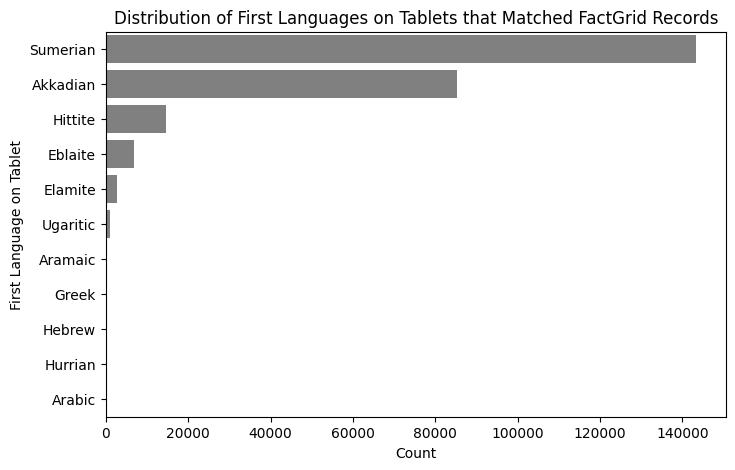

In [ ]:
plt.figure(figsize = (8, 5))
sns.barplot(data = first_l_df, y = 'first_language', x = 'count',
            color = 'grey')
plt.xlabel('Count')
plt.ylabel('First Language on Tablet')
plt.title('Distribution of First Languages on Tablets that Matched FactGrid Records');

##### Distribution of unmatched languages

First, take a look at the language of the unmatched rows.

In [ ]:
language_df.iloc[no_match_indices_lang].groupby('cdli_dump_language')['cdli_dump_language'].count()

cdli_dump_language
                              90186
Egyptian                          3
Egyptian ?                      186
Luwian                            3
Mandaic                           4
Persian                         125
Persian                           2
Persian,                          1
Persian, Babylonian               3
Persian, Elamite                  2
Persian; Elamite                  2
Persian; Elamite                  2
Persian; Elamite; Akkadian        3
Phoenician                        1
Qatabanian                       11
Sabaean                           1
Syriac                            1
Urartian                          2
no linguistic content           151
uncertain                       111
unclear                           3
undetermined                   8493
undetermined (pseudo)             1
uninscribed                       2
Name: cdli_dump_language, dtype: int64

The reason why we want to visualize the distribution of unmatched languages is to see how many unmatched records there are for each language that does not exist in FactGrid. This way, we can detmermine whether or not we need to create a new object in FactGrid for these languages.

Hence, for the sake of this visualization, we will only consider how many tablets each language has appeared on without keeping track of exactly which tablet that is.

In [ ]:
unmatched_langs = language_df.iloc[no_match_indices_lang]['cdli_dump_language']
unmatched_langs_clean = []

for l in unmatched_langs:
  # we only consider the non-empty ones
  if l != '':
    # remove the unceratinty marks
    l = l.replace(' ?', '')

    # make sure that all multiple entries are separated by ;
    l = l.replace(',', ';')

    # split a multi-language statement, if yes
    lst = l.split('; ')

    unmatched_langs_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_langs_clean = [x.rstrip() for x in unmatched_langs_clean]

# remove the empty ones
unmatched_langs_clean.remove('')

pd.unique(pd.Series(unmatched_langs_clean))

array(['undetermined', 'undetermined (pseudo)', 'no linguistic content',
       'Phoenician', 'Sabaean', 'Qatabanian', 'uncertain', 'Persian',
       'Syriac', 'Mandaic', 'uninscribed', 'Egyptian', 'Urartian',
       'Luwian', 'Elamite', 'Akkadian', 'Babylonian', 'unclear'],
      dtype=object)

In [ ]:
# get the frequencies of elements in the list
d = collections.Counter(unmatched_langs_clean)

# turn the langs and their counts into a dataframe
unmatched_l_df = pd.DataFrame.from_dict(d, orient = 'index').\
reset_index().\
rename(columns = {'index': 'language', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

# remove the ones that are already included in FactGrid
for i in range(unmatched_l_df.shape[0]):
  l = unmatched_l_df.loc[i, 'language']
  if l in lang_reference['Language'].unique():
    unmatched_l_df = unmatched_l_df.drop([i])

unmatched_l_df

,language,count
0,undetermined,8493
1,Egyptian,189
2,no linguistic content,151
3,Persian,140
4,uncertain,111
5,Qatabanian,11
7,Mandaic,4
8,Luwian,3
10,Babylonian,3
11,unclear,3


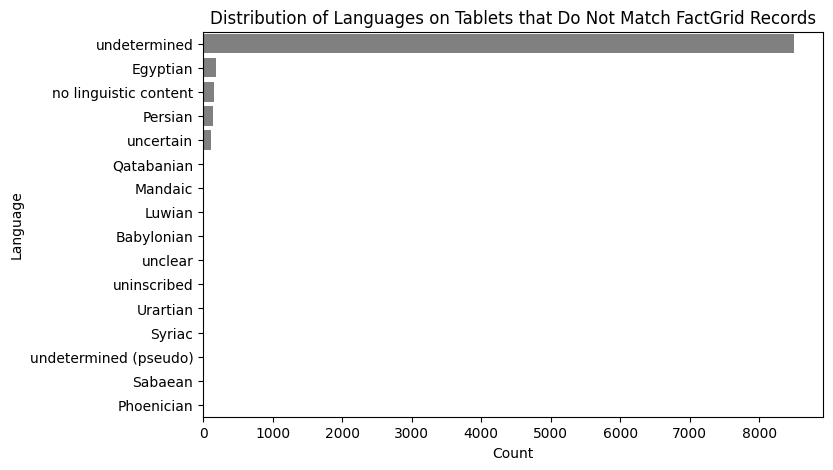

In [ ]:
plt.figure(figsize = (8, 5))
sns.barplot(data = unmatched_l_df, y = 'language', x = 'count',
            color = 'grey')
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Distribution of Languages on Tablets that Do Not Match FactGrid Records');

### 2 __material = material composition [(P401)](https://database.factgrid.de/wiki/Property:P401)__

#### 2.1. We will only add the most basic material composition to a data frame, `material_df', and then we match the first statement to the corresponding FactGrid Q-id.

We can use this CSV to obtain the corresponding FactGrid Q-id:

https://drive.google.com/file/d/12FH9ao4B-U_xIwwjcSoBfOqYoBrgRaJc/view?usp=share_link

In [ ]:
material_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Material%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

mat_reference = pd.read_csv(material_url, sep = ',')
# fill na values with space
mat_reference = mat_reference.fillna('')
# drop duplicated rows
mat_reference = mat_reference.drop_duplicates(keep = 'first')
mat_reference

,Material,FactGrid_Label,FactGrid_Q
0,?,,
1,bitumen,,
2,bone: bone,Bone,Q512051
3,bone: ivory,Bone,Q512051
4,bone: ivory ?,Bone,Q512051
...,...,...,...
102,stone: soapstone,Stone,Q254907
103,stone: steatite,Stone,Q254907
104,stone: travertine,Stone,Q254907
105,stone: tuff,Stone,Q254907


Prepare the dictonary dataframe above for matching. Please note that the following adjustments are made based on the specific cases of this google sheet. For example, we were able to simply drop the rows with question marks because for each of those rows there is another row that provides the exact same information but for the question mark. Suppose a newer version of the google sheet does not satisfy that, the following codes need to be altered.

In [ ]:
# remove entries without a FactGrid QID
mat_reference = mat_reference[mat_reference['FactGrid_Q'] != ''].reset_index()
# remove the entries with question marks because we will deal with uncertainty in the P155 column
rows_to_be_removed_mat = []
for row_no in range(mat_reference.shape[0]):
  if '?' in mat_reference.loc[row_no, 'Material']:
    rows_to_be_removed_mat += [row_no]
mat_reference = mat_reference.drop(index = rows_to_be_removed_mat)
# make sure that no new columns are included
mat_reference = mat_reference[['Material', 'FactGrid_Label', 'FactGrid_Q']]

mat_reference

,Material,FactGrid_Label,FactGrid_Q
0,bone: bone,Bone,Q512051
1,bone: ivory,Bone,Q512051
3,bone: shell,Bone,Q512051
4,clay,Clay,Q471153
5,clay; metal: bronze; stone: steatite,Clay,Q471153
...,...,...,...
97,stone: soapstone,Stone,Q254907
98,stone: steatite,Stone,Q254907
99,stone: travertine,Stone,Q254907
100,stone: tuff,Stone,Q254907


In [ ]:
short_mat_ref = mat_reference[['FactGrid_Label', 'FactGrid_Q']].drop_duplicates().reset_index(drop = True)
# lower all materail label for future matching
short_mat_ref['FactGrid_Label'] = short_mat_ref['FactGrid_Label'].apply(str.lower)

We are going to move the row of metal to the very end of the dataframe. This is to ensure that brozne, copper, gold, iron, lead, and silver are searched first in the next step. FactGrid categorizes records with material e.g., _metal: silver_ as silver and not metal. Hence, we want the smaller categories to come before the big category.

In [ ]:
metal_info = short_mat_ref.iloc[[3]]
short_mat_ref = short_mat_ref.drop(3, axis = 0)
short_mat_ref = pd.concat([short_mat_ref, metal_info])
# reset index
short_mat_ref = short_mat_ref.reset_index(drop = True)

short_mat_ref

,FactGrid_Label,FactGrid_Q
0,bone,Q512051
1,clay,Q471153
2,gypsum,Q146565
3,bronze,Q512050
4,copper,Q102059
5,gold,Q102068
6,iron,Q512047
7,lead,Q512048
8,silver,Q102025
9,shell,Q512049


#### 2.2. Make the `material_df` data frame for material_composition for all items with a matching material composition FactGrid Q-id.

See the unique values of materials in the CDLI data dump below. There are many different entries and the data entry is not very consistent. Doing a detailed string matching using the `Material` column in the reference dataframe above would be rather troublesome. This is why we created the shorter reference dataframe with only `FactGrid_Label` and `FactGrid_Q`. We will simply see if the material entry in the CDLI data dump contain the less-than-20 big labels in the shorter reference dataframe.

In [ ]:
mat_df = cdli_cat_df[['id_text', 'material']]
mat = mat_df['material']
mat.unique()

array(['clay', 'gypsum', 'stone: steatite', 'stone: limestone', 'stone',
       'stone: onyx', 'stone: slate', 'stone: basalt', 'stone: alabaster',
       'clay\x0b', 'stone: agate', 'metal: bronze', 'stone: granite',
       'stone: agate ?', 'stone: diorite', 'stone: alabaster ?', '-',
       'metal', 'stone: calcite', 'stone: marble', 'stone: rock crystal',
       'stone: calcite ?', 'stone ?', 'bitumen', 'metal: copper',
       'stone: dolomite', 'stone: haematite', 'bone: shell',
       'stone: dolerite', 'metal: gold', 'stone: quartz',
       'stone: carnelian', 'metal: bronze ?', 'clay: terracotta',
       'stone: lapis lazuli', 'stone: serpentine', 'stone: hematite',
       'stone: jasper', 'stone: greenstone', 'stone: schist',
       'stone: crystal', 'stone: aragonite', 'stone: diorite ?',
       'stone: gypsum', 'stone: shale', 'stone: limestone ?',
       'stone: syenite', 'stone: gypsum ?', 'metal: silver',
       'stone: hornfels', 'stone: porphyry', 'stone: lava',
       

But as usual, we need to first clean the material column.

In [ ]:
# remove the `\x0b` pattern
mat = np.array([re.sub('\\x0b', '', string = mat[i]) for i in range(len(mat))])
# there are different versions of NA, merge them into one
mat[mat == '-'] = ''
# lowercase all
mat = np.char.lower(mat)

# update the language dataframe
mat_df['material'] = mat

# check if the language dataframe has been properly cleaned
mat_df['material'].unique()

<ipython-input-121-b7a5195f37d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['material'] = mat


array(['clay', 'gypsum', 'stone: steatite', 'stone: limestone', 'stone',
       'stone: onyx', 'stone: slate', 'stone: basalt', 'stone: alabaster',
       'stone: agate', 'metal: bronze', 'stone: granite',
       'stone: agate ?', 'stone: diorite', 'stone: alabaster ?', '',
       'metal', 'stone: calcite', 'stone: marble', 'stone: rock crystal',
       'stone: calcite ?', 'stone ?', 'bitumen', 'metal: copper',
       'stone: dolomite', 'stone: haematite', 'bone: shell',
       'stone: dolerite', 'metal: gold', 'stone: quartz',
       'stone: carnelian', 'metal: bronze ?', 'clay: terracotta',
       'stone: lapis lazuli', 'stone: serpentine', 'stone: hematite',
       'stone: jasper', 'stone: greenstone', 'stone: schist',
       'stone: crystal', 'stone: aragonite', 'stone: diorite ?',
       'stone: gypsum', 'stone: shale', 'stone: limestone ?',
       'stone: syenite', 'stone: gypsum ?', 'metal: silver',
       'stone: hornfels', 'stone: porphyry', 'stone: lava',
       'stone: chlor

add in the matched information

In [ ]:
first_mat = []
first_mat_label = []
first_mat_qid = []
P155_mat = [] # when there's a question mark
other_mat = [] # when multiple materials
no_match_indices_mat = [] # index of the row if there's no match

FG_existing_materials = short_mat_ref['FactGrid_Label'].tolist()

for index in range(len(mat_df['material'])):
  m = mat_df['material'][index]
  # remove the space in every entry and split it by ;
  lst = m.replace(',', ';').split(';')

  # get the first material
  first_m = lst[0]

  # store the remaining materials (if exist) away
  other_mat += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_m:
    P155_mat += ['P155']
    first_m = first_m.replace('?', '')
  else:
    P155_mat += ['']

  # store the original first_m for investigating finer categories later
  first_mat += [first_m]

  # add in qid and label for the first_m

  # if the material has a QID in FactGrid
  matched = False
  for i in range(len(FG_existing_materials)):
    material = FG_existing_materials[i]
    if material in first_m:
      first_mat_label += [material]
      first_mat_qid += [short_mat_ref.loc[i, 'FactGrid_Q']]
      matched = True
      break

  # if the material does not have a FactGrid QID, put '' for everything for now
  if matched is False:
    first_mat_label += ['']
    first_mat_qid += ['']
    no_match_indices_mat += [index]

# append these columns to the dataframe
mat_df['first_mat'] = first_mat
mat_df['first_mat_label'] = first_mat_label
mat_df['first_mat_qid'] = first_mat_qid
mat_df['P155_mat'] = P155_mat
mat_df['other_mat'] = other_mat

# update the names of columns to be clearer
mat_df = mat_df.rename(columns={'id_text': 'cdli_dump_id',
                                'material': 'cdli_dump_material'})

mat_df

<ipython-input-122-3c1304c64689>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['first_mat'] = first_mat
<ipython-input-122-3c1304c64689>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df['first_mat_label'] = first_mat_label
<ipython-input-122-3c1304c64689>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,cdli_dump_id,cdli_dump_material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,1,clay,clay,clay,Q471153,,
1,2,clay,clay,clay,Q471153,,
2,3,clay,clay,clay,Q471153,,
3,4,clay,clay,clay,Q471153,,
4,5,clay,clay,clay,Q471153,,
...,...,...,...,...,...,...,...
353278,532443,clay,clay,clay,Q471153,,
353279,532444,clay,clay,clay,Q471153,,
353280,532445,clay,clay,clay,Q471153,,
353281,532446,clay,clay,clay,Q471153,,


####2.3 matched_mat_df

In [ ]:
matched_mat_df = mat_df[~mat_df.index.isin(no_match_indices_mat)].reset_index(drop = True)
matched_mat_df

,cdli_dump_id,cdli_dump_material,first_mat,first_mat_label,first_mat_qid,P155_mat,other_mat
0,1,clay,clay,clay,Q471153,,
1,2,clay,clay,clay,Q471153,,
2,3,clay,clay,clay,Q471153,,
3,4,clay,clay,clay,Q471153,,
4,5,clay,clay,clay,Q471153,,
...,...,...,...,...,...,...,...
344220,532443,clay,clay,clay,Q471153,,
344221,532444,clay,clay,clay,Q471153,,
344222,532445,clay,clay,clay,Q471153,,
344223,532446,clay,clay,clay,Q471153,,


a little sanity check:

In [ ]:
matched_mat_df.shape

(344225, 7)

In [ ]:
matched_mat_df['first_mat_label'].unique()

array(['clay', 'gypsum', 'stone', 'bronze', 'metal', 'copper', 'bone',
       'gold', 'silver', 'shell', 'iron', 'lead'], dtype=object)

##### finer categories

Now, let's see what finer categories are there under the big labels.

In [ ]:
first_mat_finer_category = []

for i in range(matched_mat_df.shape[0]):
  full_mat = matched_mat_df.loc[i, 'first_mat']
  if ': ' in full_mat:
    finer_mat = re.search('(?<=: ).*', string = full_mat).group(0)
    # remove the parenthesis
    finer_mat = finer_mat.replace('(', '').replace(')', '')
    # remove the space at the end of the string, if any
    finer_mat = finer_mat.strip()
    # check if this is a big label
    if not finer_mat in FG_existing_materials:
      first_mat_finer_category += [finer_mat]
    else:
      first_mat_finer_category += ['']
  else:
    first_mat_finer_category += ['']

matched_mat_df['first_mat_finer_category'] = first_mat_finer_category

matched_mat_df['first_mat_finer_category'].unique()

array(['', 'steatite', 'limestone', 'onyx', 'slate', 'basalt',
       'alabaster', 'agate', 'granite', 'diorite', 'calcite', 'marble',
       'rock crystal', 'dolomite', 'haematite', 'dolerite', 'quartz',
       'carnelian', 'terracotta', 'lapis lazuli', 'serpentine',
       'hematite', 'jasper', 'greenstone', 'schist', 'crystal',
       'aragonite', 'shale', 'syenite', 'hornfels', 'porphyry', 'lava',
       'chlorite', 'copper alloy', 'trachyte', 'sandstone', 'tuff',
       'obsidian', 'chalcedony', 'ivory', 'felsite', 'plaster', 'diabase',
       'feldspar', 'magnetite', 'menaccanite', 'red jasper', 'gneiss',
       'bloodstone', 'glazed pottery', 'jade-like', 'jade', 'travertine',
       'flint', 'jadeite', 'limonite', 'breccia', 'quartzite', 'black',
       'white', 'terra-cotta', 'aphrite', 'clinochlore', 'nephrite',
       'ceramic', 'iron oxide', 'amethyst', 'electrum', 'stalagmite',
       'sardonyx', 'brown', 'calcite/ dolomite', 'magnesite', 'porcelain',
       'bronze or cop

####2.4. no_match_mat_df

Make a separate dataframe of the items not matched for export and supervision: `no_material_df`.

In [ ]:
no_match_mat_df = cdli_cat_df.iloc[no_match_indices_mat]
no_match_mat_df.head()

,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
64452,213226,-,Administrative,physical cylinder seal,-,-,-,seal (not impression),Old Akkadian (ca. 2340-2200 BC),-,...,?,?,physical,-,no translation,-,-,S000602,-,-
66843,215652,-,Royal/Monumental,witness,-,-,-,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),no atf,...,?,?,statue,-,no translation,-,-,-,-,-
66963,215773,-,Private/Votive,-,-,Sumerian,-,other (see object remarks),ED IIIb (ca. 2500-2340 BC),"Foxvog, Daniel A.",...,?,?,votive dagger blade,-,no translation,-,-,-,-,-
67555,216380,-,Royal/Monumental,witness,-,-,bitumen,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),"Foxvog, Daniel A.",...,?,?,tenon,Shurush-kin.00.00.00,no translation,2/26/2003,Shurush-kin.00.00.00,-,-,-
67624,216458,-,Royal/Monumental,witness,-,-,-,other (see object remarks),Old Akkadian (ca. 2340-2200 BC),"Foxvog, Daniel A.",...,?,?,vase,Rimush.00.00.00,no translation,2/26/2003,Rimush.00.00.00,-,-,-


In [ ]:
no_match_mat_df.shape

(9058, 31)

In [ ]:
matched_mat_df.shape[0] + no_match_mat_df.shape[0] == cdli_cat_df.shape[0]

True

####2.5 Visualization

##### Distribution of matched first materials

In [ ]:
first_m_df = pd.DataFrame(matched_mat_df.groupby('first_mat_label')['first_mat_label'].count())
first_m_df.index.name = None
first_m_df = first_m_df.reset_index().rename(
    columns = {'index': 'first_material',
               'first_mat_label': 'count'}).sort_values(by = 'count', ascending = False)
first_m_df

,first_material,count
2,clay,324611
11,stone,18656
1,bronze,315
0,bone,217
5,gypsum,171
9,shell,77
3,copper,71
10,silver,34
4,gold,31
8,metal,22


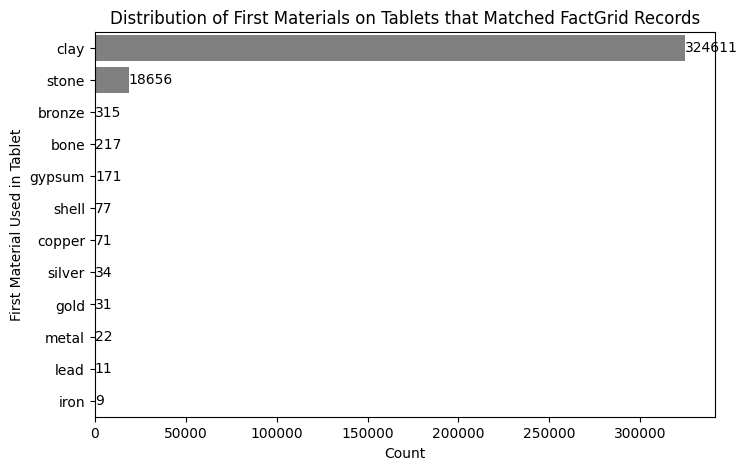

In [ ]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = first_m_df, y = 'first_material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('First Material Used in Tablet')
plt.title('Distribution of First Materials on Tablets that Matched FactGrid Records');

##### Distribution of finer categories within matched materials

We have recorded the big material labels for the matched tablets. The graph below summarizes the finer categories within those big labels.

In [ ]:
finer_cat_df = pd.DataFrame(matched_mat_df.groupby('first_mat_finer_category')['first_mat_finer_category'].count())
finer_cat_df.index.name = None
finer_cat_df = finer_cat_df.reset_index().rename(
    columns = {'index': 'material',
               'first_mat_finer_category': 'count'}).sort_values(by = 'count', ascending = False)
finer_cat_df['material'] = finer_cat_df['material'].replace([''], 'undetermined')
finer_cat_df

,material,count
0,undetermined,340133
65,limestone,1068
63,lapis lazuli,270
2,alabaster,257
35,diorite,250
...,...,...
78,polypier fossil,1
79,porcelain,1
80,porphyry,1
7,azurite,1


Note that there are unproportionately the most records that have NA value for their material. Since the purpose of this plot is to determine which labels to add into FactGrid, we will exclude the undetermined ones when we plot.

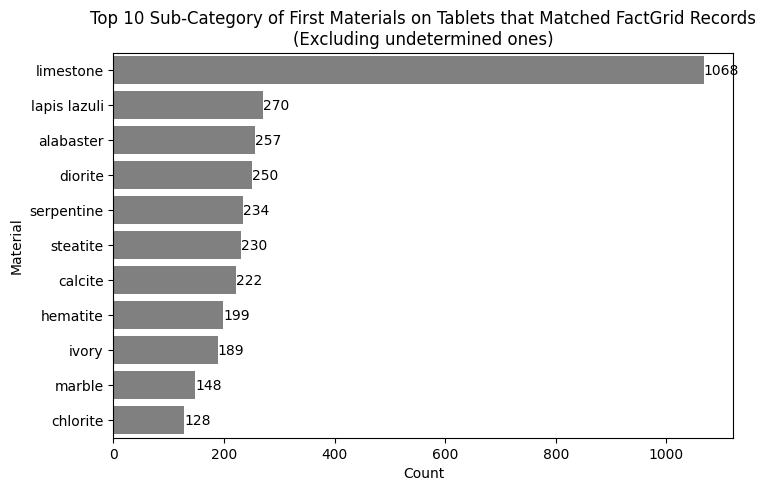

In [ ]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = finer_cat_df.iloc[1:12,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Sub-Category of First Materials on Tablets that Matched FactGrid Records\n(Excluding undetermined ones)');

##### Distribution of unmatched materials
Select the top 10 of them.

In [ ]:
unmatched_mats = mat_df.iloc[no_match_indices_mat]['cdli_dump_material']
unmatched_mats_clean = []

for m in unmatched_mats:
  # we only consider the non-empty ones
  if m != '':
    # remove the unceratinty marks
    m = m.replace(' ?', '')

    # make sure that all multiple entries are separated by ;
    m = m.replace(',', ';')

    # split a multi-language statement, if yes
    lst = m.split('; ')

    unmatched_mats_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_mats_clean = [x.rstrip() for x in unmatched_mats_clean]


pd.unique(pd.Series(unmatched_mats_clean))

array(['bitumen', 'glass', 'composite', 'wood', 'shell', 'ivory', 'blue',
       '?', 'ston', 'other', 'stone: red limestone: stone:  lapis lazuli',
       'composition', 'fossilised gastropod', 'faience', 'diorite',
       'bronze', 'chalcedony', 'calcite', 'serpentine', 'quartz',
       'marble', 'terracotta', 'carnelian', 'talc', 'schist', 'sardonyx',
       'sard', 'quartz crystal', 'gold', 'jasper', 'ceramic', 'porphyry',
       'plaster', 'agate', 'onyx', 'obsidian', 'alabaster',
       'lapis lazuli', 'hematite', 'mica', 'frit', 'stone', 'garnet',
       'clay', 'egyptian blue', 'siderite', 'cuprous sulfide', 'crystal',
       'soapstone', 'chert', 'shale', 'rock crystal', 'tuff', 'steatite',
       'basalt', 'cornelian', 'lak', 'basanite', 'flint', 'metal',
       'ophicalcite'], dtype=object)

In [ ]:
# get the frequencies of elements in the list
d_mat = collections.Counter(unmatched_mats_clean)

# turn the langs and their counts into a dataframe
unmatched_mat_counts = pd.DataFrame.from_dict(d_mat, orient = 'index').\
reset_index().\
rename(columns = {'index': 'material', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

unmatched_mat_counts

,material,count
0,composite,3598
1,serpentine,141
2,chalcedony,86
3,hematite,71
4,glass,52
...,...,...
56,obsidian,1
57,diorite,1
58,bronze,1
59,terracotta,1


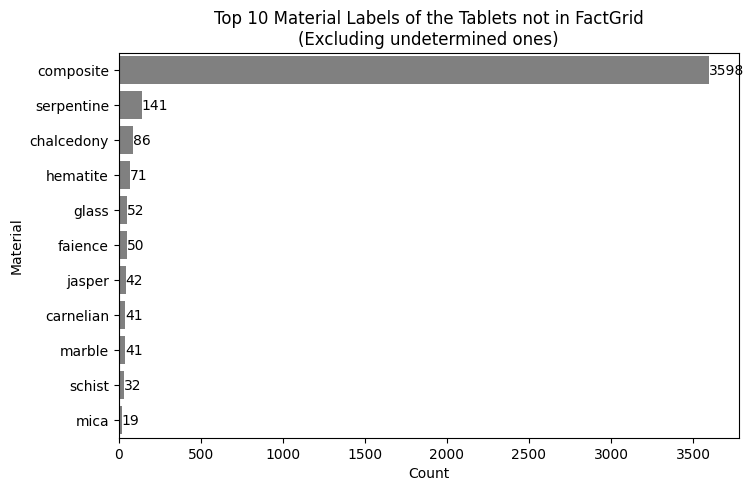

In [ ]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = unmatched_mat_counts.iloc[0:11,], y = 'material', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('Top 10 Material Labels of the Tablets not in FactGrid\n(Excluding undetermined ones)');

##### What materials are tablets that have languages on them made of?

In [ ]:
# slice the matched_mat_df with no_match_indices_lang
lang_mat_matched_df = mat_df[~language_df.index.isin(no_match_indices_lang)]
# count the materials and create a df for the material with corresponding count
lang_mat_matched_counts = pd.DataFrame(lang_mat_matched_df.groupby('first_mat_label')['first_mat_label'].count())
# rename the columns
lang_mat_matched_counts.rename(columns={lang_mat_matched_counts.columns[0]: 'count'}, inplace = True)
lang_mat_matched_counts = lang_mat_matched_counts.reset_index()
# sort the rows by count
lang_mat_matched_counts = lang_mat_matched_counts.sort_values(by = 'count', ascending = False)
lang_mat_matched_counts

,first_mat_label,count
3,clay,239724
12,stone,10375
0,,3473
2,bronze,228
6,gypsum,63
4,copper,41
5,gold,26
11,silver,14
1,bone,12
9,metal,11


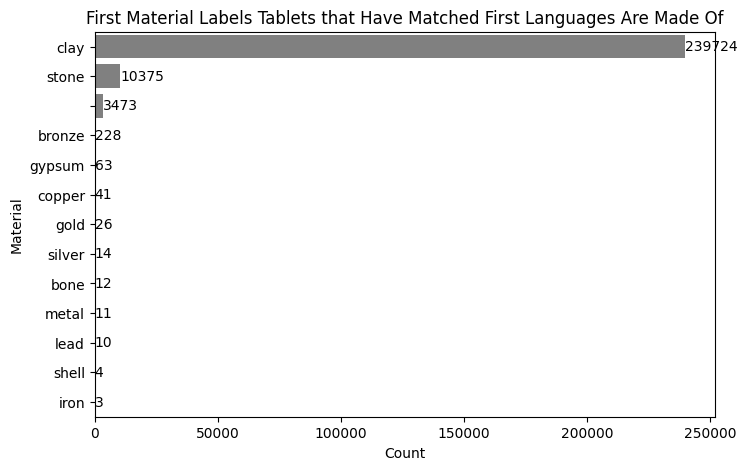

In [ ]:
plt.figure(figsize = (8, 5))
ax = sns.barplot(data = lang_mat_matched_counts, y = 'first_mat_label', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Material')
plt.title('First Material Labels Tablets that Have Matched First Languages Are Made Of');

### 3 __museum = present holding [(P329)](https://database.factgrid.de/wiki/Property:P329)__

####3.1. Next we list all the unique statements in the 'collection' field in a data frame, `museum_df` and match them with the FactGrid Q-ids.

#### 3.2. We can use this dataset, which has the corresponding FactGrid Q-ids for some, but not all (Adam will finish making the necessary Q-ids in FactGrid): https://docs.google.com/spreadsheets/d/1BdRndVP3JFGWAtv1WTlXiYsGBuCADHnblYeoihfQcLI/edit?usp=sharing
  * This sheet might need to be edited a little, but it is the most up-to-date

#### 3.3. Match on cdli label to obtain the corresponding FactGrid Q-id for 'collection' field and add matching data to `museum_df`.

#### 3.4. Include a column / field for the corresponding __'museum_no' = 'inventory position' [(P10)](https://database.factgrid.de/wiki/Property:P10)__.

#### 3.5. Make a separate data frame for the texts when there is no match / museum / collection: `no_museum_df`.

In [ ]:
cdli_cat_df['collection'].unique()

array(['Vorderasiatisches Museum, Berlin, Germany',
       'National Museum of Iraq, Baghdad, Iraq',
       'National Museum of Iraq, Baghdad, Iraq; Vorderasiatisches Museum, Berlin, Germany',
       ..., 'Mardin Museum, Mardin, Turkey', 'Oylum Höyük, Oylum, Turkey',
       'private: William T. Grant Jr., Pelham Manor, New York, USA'],
      dtype=object)

In [ ]:
cdli_cat_df['id_text'].unique()

array([     1,      2,      3, ..., 532445, 532446, 532447])

In [ ]:
cdli_cat_df['collection']

0                 Vorderasiatisches Museum, Berlin, Germany
1                 Vorderasiatisches Museum, Berlin, Germany
2                 Vorderasiatisches Museum, Berlin, Germany
3                 Vorderasiatisches Museum, Berlin, Germany
4                 Vorderasiatisches Museum, Berlin, Germany
                                ...                        
353278               National Museum of Iraq, Baghdad, Iraq
353279               National Museum of Iraq, Baghdad, Iraq
353280               National Museum of Iraq, Baghdad, Iraq
353281    private: William T. Grant Jr., Pelham Manor, N...
353282    Harvard Museum of the Ancient Near East, Harva...
Name: collection, Length: 353283, dtype: object

In [ ]:
# Here's the code that will read in a csv with the google id:
downloaded = drive.CreateFile({'id':'1BdRndVP3JFGWAtv1WTlXiYsGBuCADHnblYeoihfQcLI'}) ## Load museum.csv
downloaded.GetContentFile('museum.csv')
file_dictionary = pd.read_csv('museum.csv')
#del file_dictionary['Unnamed: 0']
#museum_url = 'https://docs.google.com/spreadsheets/d/1BdRndVP3JFGWAtv1WTlXiYsGBuCADHnblYeoihfQcLI/edit?usp=sharing'

test = pd.read_csv(museum_url, sep = ',')
test_reference = test.fillna('')
test_reference = test.drop_duplicates(keep = 'first')

test_reference
# museum_df
#cdli_subset2023
#match museum to museum no/inventory

,"<!DOCTYPE html><html><head><meta name=""google"" content=""notranslate""><meta http-equiv=""X-UA-Compatible"" content=""IE=edge;""><style nonce=""-7jBVISz62erXhPwvEUjfw"">@font-face{font-family:'Roboto';font-style:italic;font-weight:400;src:url(//fonts.gstatic.com/s/roboto/v18/KFOkCnqEu92Fr1Mu51xIIzc.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:300;src:url(//fonts.gstatic.com/s/roboto/v18/KFOlCnqEu92Fr1MmSU5fBBc9.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:400;src:url(//fonts.gstatic.com/s/roboto/v18/KFOmCnqEu92Fr1Mu4mxP.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:500;src:url(//fonts.gstatic.com/s/roboto/v18/KFOlCnqEu92Fr1MmEU9fBBc9.ttf)format('truetype');}@font-face{font-family:'Roboto';font-style:normal;font-weight:700;src:url(//fonts.gstatic.com/s/roboto/v18/KFOlCnqEu92Fr1MmWUlfBBc9.ttf)format('truetype');}</style><meta name=""referrer"" content=""origin""><title>LOD Tablet Dictionary (FG Cuneiform) - Museums.csv - Google Drive</title><meta property=""og:title"" content=""LOD Tablet Dictionary (FG Cuneiform) - Museums.csv""><meta property=""og:type"" content=""article""><meta property=""og:site_name"" content=""Google Docs""><meta property=""og:url"" content=""https://drive.google.com/file/d/1uSbm1CGOlFUG5ltAocSOjdb3VTNjFGgs/view?usp=share_link&amp;usp=embed_facebook""><link rel=""shortcut icon"" href=""https://ssl.gstatic.com/images/branding/product/1x/drive_2020q4_32dp.png""><link rel=""stylesheet"" href=""https://fonts.googleapis.com/css?family=Google+Sans_old:300",400,500,"700"" nonce=""-7jBVISz62erXhPwvEUjfw""><link rel=""stylesheet"" href=""https://www.gstatic.com/_/apps-fileview/_/ss/k=apps-fileview.v.pIJ_Rj4V7nk.L.X.O/am=AAAC/d=0/rs=AO0039sc7drzu9qAQ4lB_kZ4DLqCTTPbeg"" nonce=""-7jBVISz62erXhPwvEUjfw""><script nonce=""os1jCOurM46GM5-0qb2n8Q"">_docs_flag_initialData={""docs-ails"":""docs_cold""","docs-fwds:""docs_sdf""","docs-crs:""docs_crs_nfd""",docs-fe-re:3,docs-fl:1,docs-l1lc:2,"docs-l1lm:""IAD""",...,0.74,0.75,0.76,0.77,1].11,[[null.2,null.209,null.210,"https://www.gstatic.com/og/_/js/k=og.qtm.en_US.WZANLd38JpM.es5.O/rt=j/m=qabr,q_dnp,qapid/exm=qaaw,qadd,qaid,qein,qhaw,qhba,qhbr,qhch,qhga,qhid,qhin/d=1/ed=1/rs=AA2YrTstjkQxepxIjxvGlad9A62PfbAEbQ]]]]",};this.gbar_=this.gbar_||{};(function(_){var window=this;
0,try{,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Copyright The Closure Library Authors.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SPDX-License-Identifier: Apache-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,*/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,var Gj;Gj={};_.Hj=function(a){var b=_.Xc();a=b...,Gj)};/*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,"var Ij;try{new URL(""s://g"")",Ij=!0}catch(a){Ij=!1}_.Jj=Ij;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,_.Kj=function(a){var b,c,d=null==(c=(b=(a.ownerDocument&&a.ownerDocumen...,"script[nonce]);(b=d?d.nonce||d.getAttribute(""n...",b)};,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,var Lj=function(a,b,c){_.le.log(46,{att:a,max:b,url:c})},Nj=function(a,b,c){_.le.log(47,{att:a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
no_museum_df

### 4 __provenience = find spot [(P695)](https://database.factgrid.de/wiki/Property:P695)__

####4.1. Use this CSV to obtain the FactGrid Q-ids for each provenience location in the CDLI catalog:

https://drive.google.com/file/d/1C8hj2nVC8_qzFb8HbArbMpsx41OAV9-m/view?usp=share_link

####4.2. Matching can be done either on the cdli 'provenience' label, or on the 'cdli_id2' number [(P694)](https://database.factgrid.de/entity/P694).

####4.3. make a data frame, called `provenience_df`, for all matches of the text's 'provenience' to  FactGrid Q-id for 'find spot'.

#### 4.4 Add two columns as qualifiers:
* 'excavation_no' = [P804](https://database.factgrid.de/entity/P804) Inventory number
* 'findspot_square' = [P425](https://database.factgrid.de/entity/P425) Precision of localisation

####4.5. make a separate data frame of all texts which were not matched (or no location identified): `no_provenience_df`.

In [ ]:
provenience_df

In [ ]:
no_provenience_df

### 5 __object_type = Instance of [(P2)](https://database.factgrid.de/wiki/Property:P2)__

####5.1 Use this CSV to obtain the FactGrid Q-ids for each object type in the CDLI catalog:
https://drive.google.com/file/d/12yQ8rI-_WRSOQIcwV3TBs5xyPRHliFeK/view?usp=share_link

####5.2. Match on the cdli label for 'object_type' to obtain the FactGrid Q-id

####5.3. Make a data frame, called `object_type_df`, for all matches.

####5.4. Make a separate data frame of the texts / artifacts which were not matched: `no_object_type_df`.


In [ ]:

object_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/LOD%20Tablet%20Dictionary%20(FG%20Cuneiform)%20-%20Object.csv?raw=true'

otest = pd.read_csv(object_url, sep = ',')
otest_ref = otest.fillna('')
otest_ref = otest.drop_duplicates(keep = 'first')

otest_ref

,object_type,FG_qid,FG_Label
0,barrel,Q512054,Clay barrel
1,block,Q512055,Clay block
2,brick,Q512056,Clay brick
3,bulla,Q512057,Clay bulla
4,cone,Q512058,Clay cone
5,cylinder,Q512059,Clay cylinder
6,docket,Q512060,Clay docket
7,envelope,Q512061,Clay envelope
8,lentil,Q512062,Clay lentil tablet
9,prism,Q512063,Clay prism


In [ ]:
selected_cols = ['id_text', 'object_type']
cat = cdli_cat_df[selected_cols].copy()

merged_df = pd.merge(otest_ref, cat, on='object_type', how='outer', indicator=True)
merged_df
non_merged_rows = merged_df[merged_df['_merge'] != 'both']
merged_df = merged_df[merged_df['_merge'] == 'both']
merged_df = merged_df.drop('_merge', axis=1, )
non_merged_rows

,object_type,FG_qid,FG_Label,id_text,_merge
341024,stamp seal,Q512065,seal,NaN,left_only
341025,tablet & envelope,NaN,NaN,100163.0,right_only
341026,tablet & envelope,NaN,NaN,100174.0,right_only
341027,tablet & envelope,NaN,NaN,100176.0,right_only
341028,tablet & envelope,NaN,NaN,100193.0,right_only
...,...,...,...,...,...
353279,Seal (not impression),NaN,NaN,520818.0,right_only
353280,Seal (not impression),NaN,NaN,520819.0,right_only
353281,Seal (not impression),NaN,NaN,520820.0,right_only
353282,Seal (not impression),NaN,NaN,521434.0,right_only


In [ ]:
merged_df

,object_type,FG_qid,FG_Label,id_text
0,barrel,Q512054,Clay barrel,225433.0
1,barrel,Q512054,Clay barrel,225458.0
2,barrel,Q512054,Clay barrel,225594.0
3,barrel,Q512054,Clay barrel,225700.0
4,barrel,Q512054,Clay barrel,225779.0
...,...,...,...,...
341019,seal (not impression),Q512065,seal,530789.0
341020,seal (not impression),Q512065,seal,530790.0
341021,seal (not impression),Q512065,seal,530791.0
341022,seal (not impression),Q512065,seal,530792.0


### 6 __genre = Field of Knowledge [(P608)](https://database.factgrid.de/wiki/Property:P608)__

#### 6.1 Use this CSV to obtain the FactGrid Q-ids for each object type in the CDLI catalog:

#### 6.2 Match on the cdli label 'genre' to obtain the FactGrid Q-id.

#### 6.3 Make a data frame, called `genre_df`, for all matches.

#### 6.4. Make a separate data frame of the texts which were not matched: `no_genre_df`.

In [ ]:
genre_df

In [ ]:
no_genre_df

### 7 __period = Period [(P853)](https://database.factgrid.de/wiki/Property:P853)__

#### 7.1 Use this CSV to obtain the FactGrid Q-ids for each period of each texts in the CDLI catalog

 https://drive.google.com/file/d/1GCYneZi-SVA49iRfVMP_mH-0LFLRpIaQ/view?usp=share_link

* note that this CSV contains Wikidata Q-ids, along with the begin / end of the other chronologies (high, low, middle, etc.)

In [7]:
period_url = 'https://github.com/ancient-world-citation-analysis/CDLI2LoD/blob/main/data/Period%20-%20LOD%20Tablet%20Dictionary%20(FG%20Cuneiform).csv?raw=true'

# read in the data
# note that we fill.na with 99999999 here so that we can edit the data type of years later
period_reference = pd.read_csv(period_url, sep = ',').fillna('')

# select only the columns we want
period_reference = period_reference[['Factgrid-Q', 'cdli_period',
                                     'Wikidata_URI']]
# clean the column names
period_reference = period_reference.rename(columns = {'Factgrid-Q': 'FG_qid'})
# drop the first row that is empty
period_reference = period_reference.iloc[1: , :]
# use only rows with a QID
period_reference = period_reference[period_reference['FG_qid'] != ''].reset_index(drop = True)

period_reference

,FG_qid,cdli_period,Wikidata_URI
0,Q512118,Pre-Writing (ca. 8500-3500 BC),Q114877825
1,Q512131,Uruk V (ca. 3500-3350 BC),Q114877817
2,Q512132,Uruk IV (ca. 3350-3200 BC),Q114877809
3,Q512133,Egyptian 0 (ca. 3300-3000 BC),Q187979
4,Q512134,Uruk III (ca. 3200-3000 BC),Q114877803
5,Q512135,Proto-Elamite (ca. 3100-2900 BC),Q1196237
6,Q512136,Early Dynastic Period,Q716742
7,Q512137,ED I,Q99299898
8,Q512137,ED I-II (ca. 2900-2700 BC),Q99299898
9,Q512139,ED II,Q99299906


####7.2 Match on the CDLI 'period' label to obtain the FactGrid Q-id.

 Make a data frame, called `period_df`, for all matches.
* if there's a question mark in the CDLI for period, you can use the same method as the `language_df` above, by adding the following column:

| id_text | period | [(P155)](https://database.factgrid.de/wiki/Property:P155)|
| -- | ------- | ------ |
|  'id_text' in cdli_cat.csv |'period' in cdli_cat.csv | [Q22757](https://database.factgrid.de/wiki/Item:Q22757)|

Make a separate data from of the texts which were not matched: `no_period_df`.

In [8]:
period_df = cdli_cat_df[['id_text', 'period']]
period_df = period_df.rename(columns = {'period': 'cdli_dump_period'})
period_df['cdli_dump_period'].unique()

array(['Uruk III (ca. 3200-3000 BC)', 'Uruk IV (ca. 3350-3200 BC)',
       'ED I-II (ca. 2900-2700 BC)', 'Uruk V (ca. 3500-3350 BC)',
       'Uruk V (ca. 3500-3350 BC) ?', 'ED IIIa (ca. 2600-2500 BC)',
       'Proto-Elamite (ca. 3100-2900 BC)', 'uncertain',
       'Pre-Uruk V (ca. 8500-3500 BC)',
       'Old Babylonian (ca. 1900-1600 BC)',
       'ED I-II (ca. 2900-2700 BC) ?', 'ED IIIb (ca. 2500-2340 BC)',
       'Ur III (ca. 2100-2000 BC)', 'Old Akkadian (ca. 2340-2200 BC)',
       'Lagash II (ca. 2200-2100 BC)', 'Lagash II (ca. 2200-2100 BC) ?',
       'Old Babylonian (ca. 1900-1600 BC) ?',
       'Ur III (ca. 2100-2000 BC) ?',
       'Early Old Babylonian (ca. 2000-1900 BC)',
       'Old Akkadian (ca. 2340-2200 BC) ?',
       'Neo-Babylonian (ca. 626-539 BC)',
       'Early Old Babylonian (ca. 2000-1900 BC) ?',
       'Old Assyrian (ca. 1950-1850 BC)', 'Achaemenid (547-331 BC)',
       'ED IIIb (ca. 2500-2340 BC) ?', 'Neo-Assyrian (ca. 911-612 BC)',
       'Old Akkadian (ca. 2340-2

Typically, we need to clean this first, but the period data looks pretty neat after manual inspection so we will skip for now.

In [42]:
cdli_cat_df.loc[4196, 'period']

'Uruk V (ca. 3500-3350 BC) ?'

In [46]:
period = []
period_qid = []
period_wikidata_URI = []
P155_period = [] # when there's a question mark
other_possible_period = [] # when there are multiple estimations of period
no_match_indices_period = [] # index of the row if there's no match
index = 4196
p = period_df['cdli_dump_period'][index]
lst = p.replace(',', ';').replace('or', ';').split(';')
first_p = lst[0].rstrip()

if '?' in first_p:
    P155_period += ['P155']
    first_p = first_p.replace('?', '')
else:
    P155_period += ['']

first_p

'Uruk V (ca. 3500-3350 BC) '

In [47]:
period = []
period_qid = []
period_wikidata_URI = []
P155_period = [] # when there's a question mark
other_possible_period = [] # when there are multiple estimations of period
no_match_indices_period = [] # index of the row if there's no match


for index in range(len(period_df['cdli_dump_period'])):
  p = period_df['cdli_dump_period'][index]
  # split every entry by ;
  lst = p.replace(',', ';').replace('or', ';').split(';')

  # get the first estimated period
  first_p = lst[0].rstrip()

  # store the remaining estimations (if exist) away
  other_possible_period += [', '.join(lst[1:])]

  # check for uncertainty
  if '?' in first_p:
    P155_period += ['P155']
    first_p = first_p.replace('?', '').rstrip()
  else:
    P155_period += ['']


  # add in qid and label for the first_p

  # if the period has a QID in FactGrid
  if first_p in period_reference['cdli_period'].unique():
    # record the period
    period += [first_p]
    # get the corresponding QID (FG_item) and Wikidata_URI
    i = period_reference['cdli_period'].tolist().index(first_p)
    period_qid += [period_reference['FG_qid'][i]]
    period_wikidata_URI += [period_reference['Wikidata_URI'][i]]

  # if the period does not have a FactGrid QID, put '' for everything for now
  else:
    period += ['']
    period_qid += ['']
    period_wikidata_URI += ['']
    no_match_indices_period += [index]


# append these columns to the dataframe
period_df['period'] = period
period_df['period_qid'] = period_qid
period_df['period_wikidata_URI'] = period_wikidata_URI
period_df['P155_period'] = P155_period
period_df['other_possible_period'] = other_possible_period

# update the names of columns to be clearer
period_df = period_df.rename(columns={'cdli_period': 'cdli_dump_period'})

period_df

,id_text,cdli_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,1,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
1,2,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
2,3,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
3,4,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
4,5,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
...,...,...,...,...,...,...,...
353278,532443,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
353279,532444,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
353280,532445,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
353281,532446,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,


In [48]:
period_df.shape

(353283, 7)

#### 7.3 matched_period_df

In [49]:
matched_period_df = period_df[~period_df.index.isin(no_match_indices_period)].reset_index(drop = True)
matched_period_df

,id_text,cdli_dump_period,period,period_qid,period_wikidata_URI,P155_period,other_possible_period
0,1,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
1,2,Uruk III (ca. 3200-3000 BC),Uruk III (ca. 3200-3000 BC),Q512134,Q114877803,,
2,3,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
3,4,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
4,5,Uruk IV (ca. 3350-3200 BC),Uruk IV (ca. 3350-3200 BC),Q512132,Q114877809,,
...,...,...,...,...,...,...,...
329566,532443,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
329567,532444,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
329568,532445,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,
329569,532446,Old Babylonian (ca. 1900-1600 BC),Old Babylonian (ca. 1900-1600 BC),Q512152,Q114877765,,


In [50]:
matched_period_df.shape

(329571, 7)

#### 7.4 no_match_period_df

In [51]:
no_match_period_df = cdli_cat_df.iloc[no_match_indices_period]
no_match_period_df.head()

,id_text,external_id,genre,subgenre,subgenre_remarks,language,material,object_type,period,atf_source,...,thickness,width,object_remarks,date_of_origin,translation_source,date_entered,dates_referenced,seal_id,accounting_period,citation
6917,9167,-,Administrative,-,-,undetermined,clay,tablet,uncertain,"Dahl, Jacob L.",...,12,21,-,-,no translation,12/4/2001,-,-,-,-
7182,9446,-,Administrative,-,-,undetermined,clay,tablet,uncertain,cdlistaff (check),...,?,?,-,-,no translation,12/4/2001,-,-,-,-
7214,9479,-,Administrative,-,-,undetermined,clay,other (see object remarks),Pre-Uruk V (ca. 8500-3500 BC),cdlistaff,...,?,?,disk with SAL sign,-,no translation,12/4/2001,-,-,-,-
68793,217673,-,Mathematical,-,-,-,clay,tablet,uncertain,cdlistaff,...,15,30,-,-,no translation,-,-,-,-,"s. Foster, Benjamin R., and Robson, Eleanor, Z..."
68794,217674,-,Mathematical,-,-,-,clay,tablet,uncertain,cdlistaff,...,?,?,-,-,no translation,-,-,-,-,"s. Foster, Benjamin R., and Robson, Eleanor, Z..."


In [52]:
no_match_period_df.shape

(23712, 31)

In [53]:
matched_period_df.shape[0] + no_match_period_df.shape[0] == cdli_cat_df.shape[0]

True

#### Visualization

##### Distribution of matched periods

In [54]:
matched_period_counts = pd.DataFrame(matched_period_df.groupby('period')['period'].count())
matched_period_counts.index.name = None
matched_period_counts = matched_period_counts.reset_index().rename(
    columns = {'index': 'period',
               'period': 'count'}
    ).sort_values(by = 'count', ascending = False).reset_index(drop = True)
matched_period_counts

,period,count
0,Ur III (ca. 2100-2000 BC),111285
1,Old Babylonian (ca. 1900-1600 BC),66827
2,Neo-Assyrian (ca. 911-612 BC),35661
3,Neo-Babylonian (ca. 626-539 BC),17516
4,Middle Hittite (ca. 1500-1100 BC),14692
5,Middle Babylonian (ca. 1400-1100 BC),12915
6,Old Akkadian (ca. 2340-2200 BC),10200
7,Early Old Babylonian (ca. 2000-1900 BC),8630
8,Ebla (ca. 2350-2250 BC),7112
9,Old Assyrian (ca. 1950-1850 BC),6620


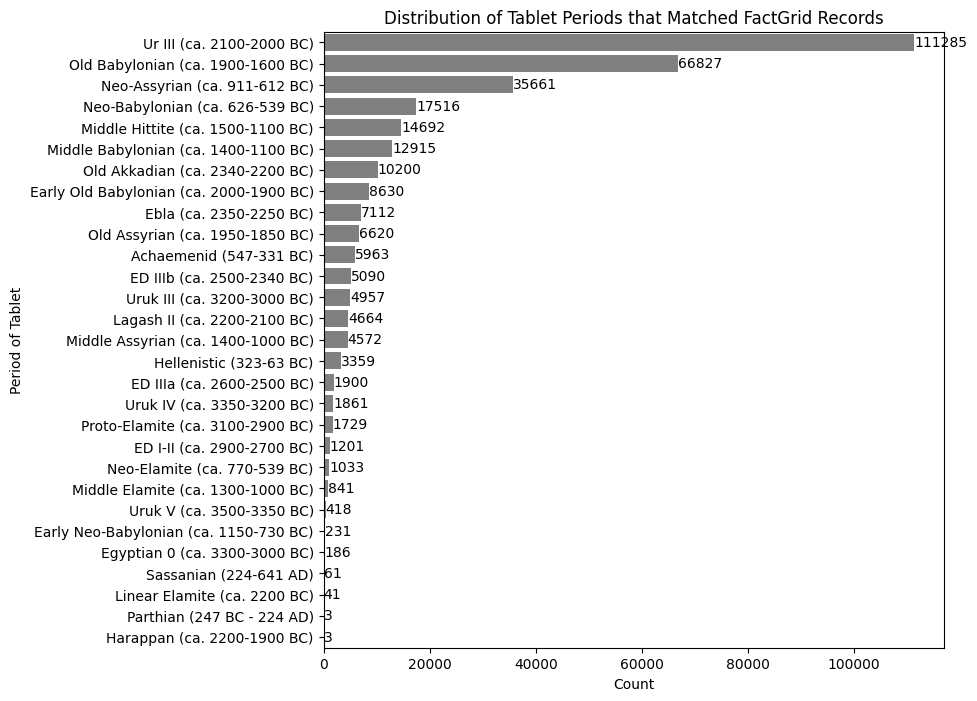

In [55]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Periods that Matched FactGrid Records');

##### Distribution of matched tablets over time

In [56]:
start_year_of_period = []

for i in range(matched_period_counts.shape[0]):
  current_period = matched_period_counts.loc[i, 'period']
  # only take what's between ()
  year_range = re.search('\(([^\)]+)\)', string = current_period).group(1)
  # remove 'ca.' and space to prepare for string manipulation
  year_range = year_range.replace('ca. ', '').replace(' ', '')

  if 'BC' in year_range:
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('BC')[0]
    elif 'AD' in year_range: # i.e., this range crosses AD and BC
      start_year = year_range.split('BC')[0]
    else: #i.e., this is a normal range within BC
      start_year = year_range.split('-')[0]
    # since this is a BC year, make it negative
    start_year = -abs(int(start_year))

  else: #'AD' only years
    if '-' not in year_range: # i.e., this is not a range
      start_year = year_range.split('AD')[0]
    else:
      start_year = year_range.split('-')[0]
  start_year = int(start_year)

  start_year_of_period += [start_year]

matched_period_counts['start_year_of_period'] = start_year_of_period
# order the df by start_year_of_period
matched_period_counts = matched_period_counts.sort_values('start_year_of_period', ascending = True)

matched_period_counts

,period,count,start_year_of_period
22,Uruk V (ca. 3500-3350 BC),418,-3500
17,Uruk IV (ca. 3350-3200 BC),1861,-3350
24,Egyptian 0 (ca. 3300-3000 BC),186,-3300
12,Uruk III (ca. 3200-3000 BC),4957,-3200
18,Proto-Elamite (ca. 3100-2900 BC),1729,-3100
19,ED I-II (ca. 2900-2700 BC),1201,-2900
16,ED IIIa (ca. 2600-2500 BC),1900,-2600
11,ED IIIb (ca. 2500-2340 BC),5090,-2500
8,Ebla (ca. 2350-2250 BC),7112,-2350
6,Old Akkadian (ca. 2340-2200 BC),10200,-2340


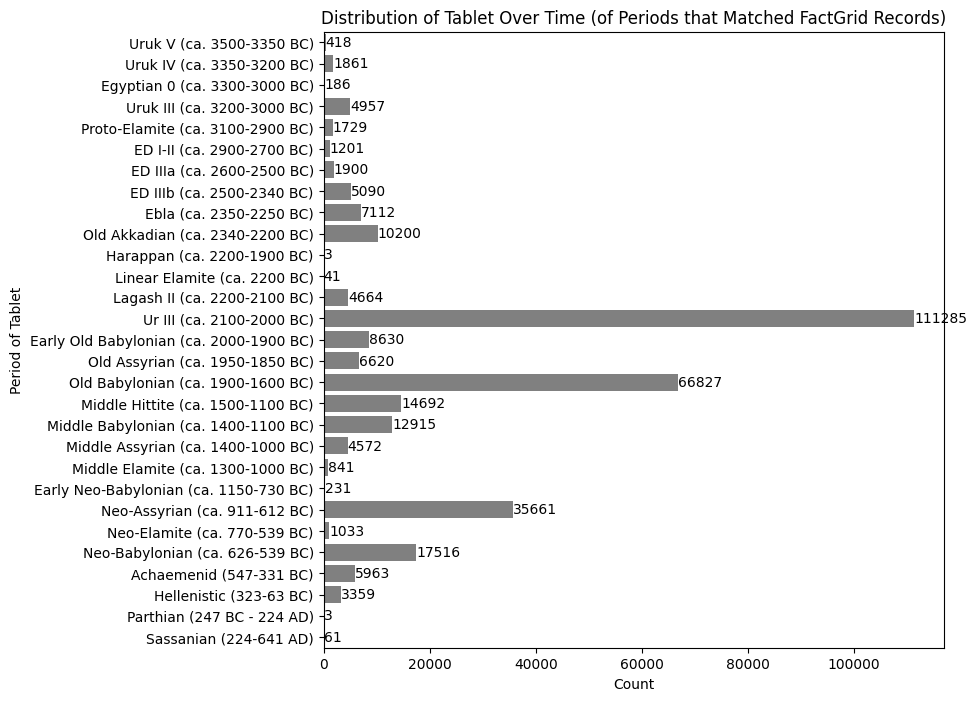

In [57]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = matched_period_counts, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Period of Tablet')
plt.title('Distribution of Tablet Over Time (of Periods that Matched FactGrid Records)');

##### Distribution of Unmatched Periods

In [58]:
period_df.iloc[no_match_indices_period].groupby('cdli_dump_period')['cdli_dump_period'].count()

cdli_dump_period
-                                                                       22110
1200-700 BC                                                                 1
Achaemenid (547–331 BC)                                                    50
Achaemenid?                                                                 4
Early Dynastic IIIA (c. 2700-2500 BC)                                       1
Early Old Babylonian (ca. 1900-1600 BC)                                     1
Middle Babylonian (ca. 1400-1100 BC))                                       1
Neo-Babylonian (626-539 BC)                                               258
Neo-Babylonian (ca. 626-539 BC).                                            1
Old Babylonian                                                              6
Old Elamite (ca. 2700-1500 BC)                                              1
Parthian (247 BC-224 AD)                                                   18
Pre-Uruk V (ca. 8500-3500 BC)                  

In [59]:
unmatched_periods = period_df.iloc[no_match_indices_period]['cdli_dump_period']
unmatched_periods_clean = []

for p in unmatched_periods:
  if 'modern' in p:
    unmatched_periods_clean += ['modern']

  # we only consider the non-empty ones
  elif (p != '') & (p != '-'):
    # remove the unceratinty marks
    p = p.replace('?', '').rstrip()

    # make sure that all multiple entries are separated by ;
    p = p.replace(',', ';')

    # split a multi-period statement, if yes
    lst = p.split('; ')

    unmatched_periods_clean += lst

# remove the space attached to some entries which are resulted from splitting by ;
unmatched_periods_clean = [x.rstrip() for x in unmatched_periods_clean]


pd.unique(pd.Series(unmatched_periods_clean))

array(['uncertain', 'Pre-Uruk V (ca. 8500-3500 BC)', 'modern',
       'Neo-Babylonian (626-539 BC)', 'Parthian (247 BC-224 AD)',
       'Achaemenid (547–331 BC)', 'fake (ancient)',
       'Old Elamite (ca. 2700-1500 BC)', 'Achaemenid', 'Old Babylonian',
       'Early Old Babylonian (ca. 1900-1600 BC)',
       'Early Dynastic IIIA (c. 2700-2500 BC)',
       'Uruk III (ca. 3200-3000 BC) - Early Dynastic I-II (ca. 2900-2700 BC)',
       '1200-700 BC', 'Middle Babylonian (ca. 1400-1100 BC))',
       'Neo-Babylonian (ca. 626-539 BC).'], dtype=object)

In [60]:
# get the frequencies of elements in the list
d = collections.Counter(unmatched_periods_clean)

# turn the langs and their counts into a dataframe
unmatched_p_df = pd.DataFrame.from_dict(d, orient = 'index').\
reset_index().\
rename(columns = {'index': 'period', 0: 'count'}).\
sort_values(by = 'count', ascending = False).\
reset_index().\
drop(columns = 'index')

unmatched_p_df

,period,count
0,uncertain,847
1,Neo-Babylonian (626-539 BC),258
2,Pre-Uruk V (ca. 8500-3500 BC),219
3,modern,192
4,Achaemenid (547–331 BC),50
5,Parthian (247 BC-224 AD),18
6,Old Babylonian,6
7,Achaemenid,4
8,fake (ancient),1
9,Old Elamite (ca. 2700-1500 BC),1


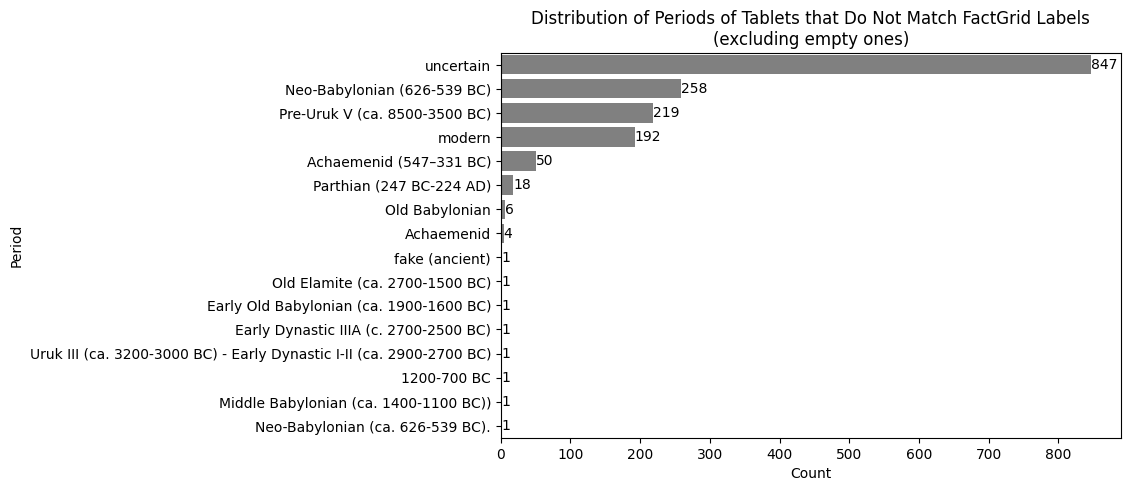

In [62]:
plt.figure(figsize = (8, 5))
sns.barplot(data = unmatched_p_df, y = 'period', x = 'count',
            color = 'grey')
ax = sns.barplot(data = unmatched_p_df, y = 'period', x = 'count',
                 color = 'grey')
ax.bar_label(ax.containers[0], fmt = '%g')
plt.xlabel('Count')
plt.ylabel('Period')
plt.title('Distribution of Periods of Tablets that Do Not Match FactGrid Labels\n(excluding empty ones)');

## III. Concatenate resulting matched data frames

Continuing with the cleaned up `cdli_cat_df`, we next want to concatenate the data frames from above, but only those which found the corresponding matches with FactGrid Q-ids. The resulting data frame, called `cdli_cat_2_df` will concatenate the following data frames on the basis of the each text, i.e. 'cdli_id' + 'designation', matching to the following:
1. `language_df`
2. `material_df`
3. `museum_df`
4. `provenience_df`
5. `object_type_df`
6. `genre_df`
7. `period_df`

In [ ]:
cdli_cat_2_df

## IV. Prepare for __FactGrid__ QuickStatement batch processing

Once the `cdli_cat_2_df` is properly joined together (i.e. concatenated), the last step before we export the resulting CSV is to include the FactGrid statements into the data frame, which we will call `cdli_cat_2_factgrid_df`.

Most of this process is straightforward, but the one statement we need to create is a __description__ for each object.
###1 To do so we will use a couple of the cleaned up fields from `cdli_cat_2_df` above and add a new field with header 'Den' which will join three existing columns together to form a descriptive sentence.

###2 For each object with a 'cdli_id' + 'designation' we will make the description by joining the following fields:
 * 'lang' +
 * 'genre' +
 * 'object' +
 * " from " +
 * 'provenience = Len' + (the CDLI 'provenience' field has many missing fields, so we will use the 'Len' field instead)
 * ", dated to " +
 * 'period' +
 * " and currently held in the" +
 * 'collection'

###3 The result should look something like this: __"Sumerian administrative tablet from Girsu, dated to Ur III (ca. 2100-2000 BC) and currently held in the British Museum, London, UK"__

###4 The final resulting data frame (`cdli_cat_2_factgrid_df`) will include the following fields, with data from `cdli_cat_2_df` in single quotation marks (' '). This includes a total of 15 columns new columns added at the beginning of the data frame:

#### 4.1 Initial fields with __description__:

| qid | Len | Den | P2 | P131 | P692 |
| --- | --- | --- | ---- | --- | --- |
| (blank) | 'designation' | __description__ | [Q390181](https://database.factgrid.de/wiki/Item:Q390181) (for all) | [Q389597](https://database.factgrid.de/wiki/Item:Q389597) (for all) | 'id_text' |

#### 4.2 __language_df__ (continued):

| Language | P18 | P155 | Lang2 | P18 |
| ----- |------ | ---- | ---- | --- |
Akkadian (for example) | [Q471146](https://database.factgrid.de/wiki/Item:Q471146) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)| Sumerian (for example) |[Q471149](https://database.factgrid.de/wiki/Item:Q471149) (for example)|

#### 4.3 __material_df__ (continued):

| Material composition | P401 |
| ------ | ---- |
|clay (for example) | [Q471153](https://database.factgrid.de/wiki/Item:Q471153) |

#### 4.4 __museum_df__ (continued):

| Present holding | P329 | P10 + [qualifier](https://database.factgrid.de/wiki/Item:Q499887#) |
| ------ | ---- | ----------- |
British Museum (for example) | [Q102010](https://database.factgrid.de/wiki/Item:Q102010) | 'museum_no' |

#### 4.5 __provenience_df__ (continued):
| Provenience | P695 | P804 | P425 |
| ----------- | ---- | ---- | ---- |
| 'Len' = Kanesh (for example)| [Q390036](https://database.factgrid.de/wiki/Item:Q390036) | "kt a/k 0353" |  |

  * Note: these qualifiers for 'excavation_no' and 'findspot_square' will make issues for QuickStatements, because there will be a lot of null values. We will need to add these in separate batches.


#### 4.6 __object_type_df__ (continued):

| Instance of | P2 |
| ---- | ---- |
| Tablet (for example) | [Q512006](https://database.factgrid.de/wiki/Item:Q512006) |

#### 4.7 __genre_df__ (continued):

| Type of work | P121 | P608 |
| ---- | ---- | ---- |
| Letter (for example) | [Q10510](https://database.factgrid.de/wiki/Item:Q10510) (for example)| [Q257175](https://database.factgrid.de/wiki/Item:Q257175) (for example)|

#### 4.8 __period_df__ (continued):

| Period | P853 | P155 |
| ---- | ---- | ---- |
| Old Assyrian Period (for example) | [Q512151](https://database.factgrid.de/wiki/Item:Q512151) | [Q22757](https://database.factgrid.de/wiki/Item:Q22757) (if questionable)|

#### Finalized outcome (example in FactGrid):
[__ICK 4 - I 437 (Q499899)__](https://database.factgrid.de/wiki/Item:Q499899)

This example shows how each statement will look for each text we are adding to FactGrid using QuickStatements.

In [ ]:
cdli_cat_2_factgrid_df

In [ ]:
df = pd.DataFrame(cdli_cat_2_factgrid_df)

# saving the dataframe to designated folder
f = "cdli_cat_2_factgrid_df.csv"

with open(folder+f, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

## V. Next steps (Version 1.2): AA will prepare the CSV equivalencies for the following fields from the CDLI_CAT.CSV file:

### 1 __'date_of_origin' / 'dates_referenced'__:
These two fields look identical in the cdli_cat.csv, but they are very messy and require a lot of cleaning. AA started this work with another student in September of 2022. We came up with the following Jupyter Notebook (and white paper), and AA added about half of the list to Wikidata. This needs to be completed, but to so so, the remaining c. 250 rulers needs to be supervised by hand before we make Qids for them.

The general concept is that we use three metrics for dates, first, the _periods_ (which we included above), second, _dynasties_ (which we deal with in the chronology.ipynb), and third, the _rulers_ and their documented years of reign.
  * Chronology Notebook: [chronology.ipynb](https://colab.research.google.com/drive/1ZYWIapSC6za-WJd6EOA7xjSm6o6CPKPu?usp=share_link)
  * White peper: [Chronology Notes](https://docs.google.com/document/d/1mw2shUyDBI56i3YqqaPipZwJH69XHlB_fzP9V32TiMc/edit?usp=share_link)


### 2 __'subgenre'__:
This field needs a lot of cleaning still, but there are a lot of valuable typologies to use for linked data.



### __seal = CDLI ID [(P2474)](https://www.wikidata.org/wiki/Property:P2474)__

If there is an ID present for an item in the 'seal' column, we want to link that as well. To do so, we will need to make a separate data frame for to create this new batch of items, before we can link them to their corresponding texts.

####1 Use this subset of the cdli_cat.csv to begin with, but check for updates as this was made in 2022, and we will need to link to the reference source [(P850)](https://database.factgrid.de/entity/P850)

####2 Format the data frame with the 'seal' ID as the first data column, and the second column with the FactGrid Q-id corresponding to 'id_text' (this is why we need to do this in a second batch).

###3 The resulting data frame should look like this:

| qid | Len | Den | P2 | P8 | P850 | P146 |
| --- | --- | --- | -- | -- | ---- | ---- |
| (blank) | 'seal_id' | (online info?) | [Q512065](https://database.factgrid.de/wiki/Item:Q512065) | Q-id for 'id_text' if CDLI| (website/source) | URL |

Notes:
* the description would ideally match the one given from the CDLI or website where the seal is published
* the reference source would indicate which website the seals were coming from
* the corresponding 'online information' is for the url, which would need to be obtained from an API call
* lots of work still to do here...